In [1]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
import copy
import numpy as np




In [2]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 50
RUN_NAME = f"CORRECTLY_{CHECKPOINT}_ckpt_short_more_data"
MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1"
EPOCHS = 101
EVAL_EVERY = 10
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"
os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(GIF_PATH, exist_ok=True)


In [3]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=3,
        number_of_boxes_max=7,
        number_of_moving_boxes_max=5
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [4]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl


In [5]:
@jax.jit
def make_batch(buffer_state, key):
    key, batch_key, double_batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
    if not config.exp.use_targets:
        state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
        future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        'observations': state.grid.reshape(state.grid.shape[0], -1),
        'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actions': actions.squeeze(),
        'rewards': state.reward.reshape(state.reward.shape[0], -1),
        'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
        'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

def value_transform(x):
    return jnp.log(jnp.maximum(x, 1e-6))

# Data creation

In [6]:
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

2025-08-20 20:44:21.237563: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


data transformation

check if transitions are correct

In [7]:
for i in range(30):
    print("________________")
    print(timesteps.grid[i, 0])
    print(timesteps.goal[i, 0])
    

________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 6  0  0  0  0]
 [ 2  0  1  2  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 2  3  0  0  0]
 [ 2  0  1  2  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 2  0  3  0  0]
 [ 2  0  1  2  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 2  0  0  3  0]
 [ 2  0  1  2  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
________________
[[ 0 10  2  0  0]
 [ 2  1  1  0  0]
 [ 2  0  0  0  0]
 [ 2  0  1  6  0]
 [ 0  0  0  1  1]]
[[ 0 10 10  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0 10  0]
 [ 0  0  0  0  0]]
_____

check if envs are differen

In [8]:
timesteps.grid[0, :10]

Array([[[ 0, 10,  2,  0,  0],
        [ 2,  1,  1,  0,  0],
        [ 6,  0,  0,  0,  0],
        [ 2,  0,  1,  2,  0],
        [ 0,  0,  0,  1,  1]],

       [[ 0,  2,  0,  0,  0],
        [ 1,  0,  0,  0,  1],
        [ 6,  0,  1,  0,  0],
        [ 0,  1,  0,  2,  0],
        [ 0,  2,  2,  0,  1]],

       [[ 0,  0,  0,  1,  1],
        [ 0,  0,  2,  0,  1],
        [ 0,  2,  1,  0,  0],
        [ 3,  0,  0,  0,  0],
        [ 0,  1,  2,  2,  2]],

       [[ 0,  0,  1,  2,  2],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  2,  3,  0],
        [ 0,  1,  0,  0,  0],
        [ 0,  0,  1,  0,  0]],

       [[ 2, 10,  0,  1,  0],
        [ 0,  0,  0,  2,  0],
        [ 1,  0,  0,  1,  3],
        [ 0,  0,  0,  0,  2],
        [ 1,  2,  1, 10,  2]],

       [[ 2,  0,  3,  0,  0],
        [ 0,  0,  0,  2,  0],
        [10,  1,  0,  1,  0],
        [10,  1,  2,  0,  2],
        [ 0,  1,  2,  0,  1]],

       [[ 1,  0,  0,  0,  0],
        [ 1,  0,  2,  0,  0],
        [ 3,  0,  2,  1,  1]

In [9]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=GridStatesEnum.remove_targets(timesteps.grid),
        goal=GridStatesEnum.remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal
tr_states.shape, tr_goals.shape, tr_actions.shape

((100, 1024, 5, 5), (100, 1024, 5, 5), (100, 1024))

In [10]:
tr_states, tr_goals, tr_actions = tr_states.reshape((-1, tr_states.shape[-2],tr_states.shape[-1])), tr_goals.reshape((-1, tr_goals.shape[-2],tr_goals.shape[-1])), tr_actions.reshape((-1,))
tr_states.shape, tr_goals.shape, tr_actions.shape

((102400, 5, 5), (102400, 5, 5), (102400,))

In [11]:
tr_states, tr_goals = tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1)
tr_states.shape, tr_goals.shape, tr_actions.shape

((102400, 25), (102400, 25), (102400,))

In [12]:
timesteps.grid[0,0]

Array([[ 0, 10,  2,  0,  0],
       [ 2,  1,  1,  0,  0],
       [ 6,  0,  0,  0,  0],
       [ 2,  0,  1,  2,  0],
       [ 0,  0,  0,  1,  1]], dtype=int8)

In [13]:
for i in range(0, 102400, 1024):
    print("________________")
    print(tr_states[i].reshape(5,5))
    print(tr_goals[i].reshape(5,5))

________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [3 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 3 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 3 0 0]
 [0 0 1 0 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 0 3 0]
 [0 0 1 0 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 0 1 3 0]
 [0 0 0 1 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 5 1]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [5 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
________________
[[0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 4 1]]
[[0 1 1 0 0]
 [1 0 0 0 

I'm calculating q values with goals, which are from environment!!!! 

In [14]:
qs = []
CHKPT_EVERY = 10
for ckpt in range(0,CHECKPOINT+1,CHKPT_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    q1, q2 = agent.network.select('critic')(tr_states, tr_goals, tr_actions)
    q = np.concat([q1, q2])
    qs.append(q)
qs = np.array(qs)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /h

In [15]:
qs.shape

(6, 204800)

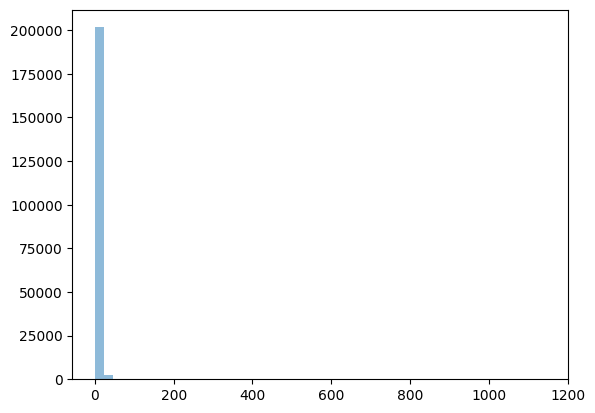

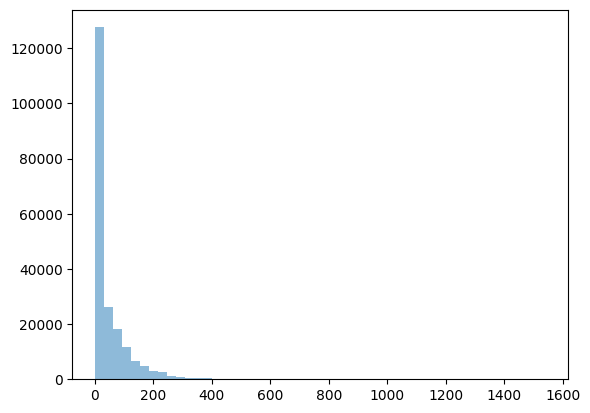

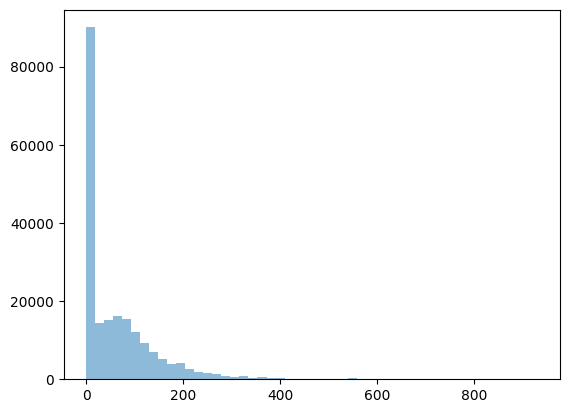

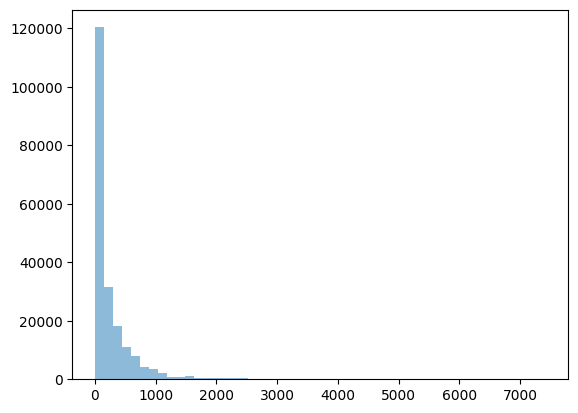

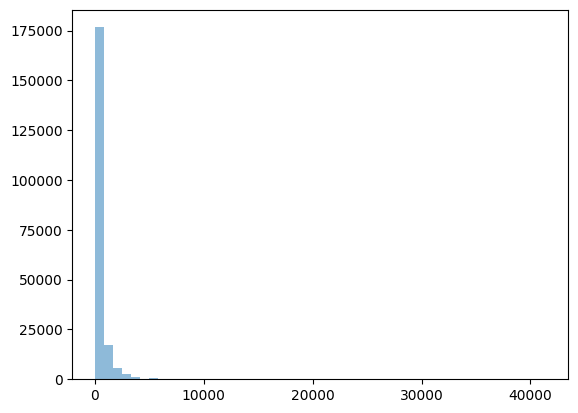

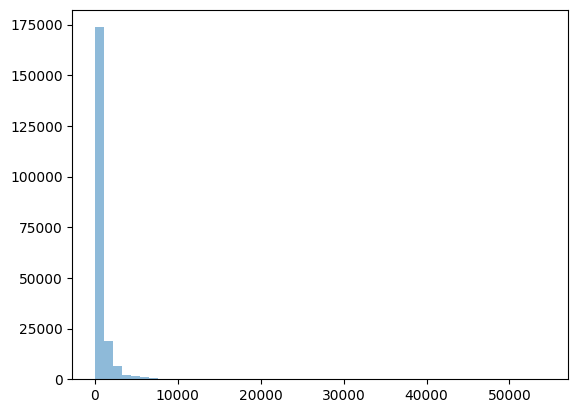

In [16]:
for i in range(qs.shape[0]):
    plt.hist(qs[i], bins=50, alpha=0.5, label=f'ckpt {i*CHKPT_EVERY}')
    plt.show()

In [17]:
# Find top N indices for each row in qs
N = 5000
top_indices_per_row = [np.argsort(qs[row])[-N:][::-1] for row in range(1, qs.shape[0])]

# Compute intersection between all rows' top indices
intersection = set(top_indices_per_row[0])
for idxs in top_indices_per_row[1:]:
    intersection &= set(idxs)

print(f"Intersection of top {N} indices across all rows:", intersection)
print(f"Number of intersecting indices: {len(intersection)}")

Intersection of top 5000 indices across all rows: set()
Number of intersecting indices: 0


# Q plots

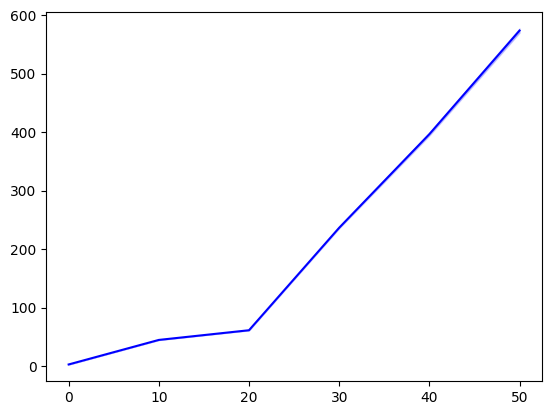

In [18]:
mean_q = np.array(qs).mean(axis=1)
std_err_q = np.array(qs).std(axis=1) / np.sqrt(np.array(qs).shape[1])
x = np.arange(0, CHECKPOINT+1, CHKPT_EVERY)
plt.plot(x, mean_q, label='Mean Q', color='blue')
plt.fill_between(x, mean_q - std_err_q, mean_q + std_err_q, color='blue', alpha=0.2, label='StdErr Q')


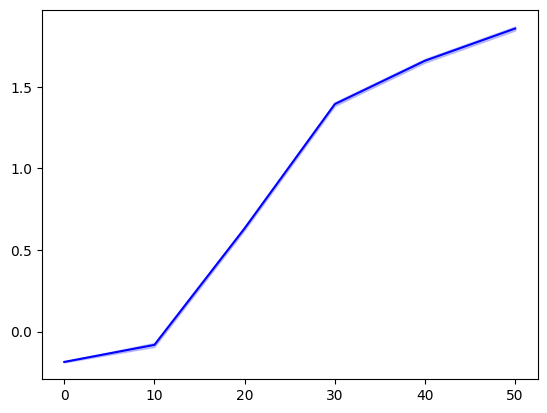

In [19]:
qs_log = value_transform(qs)
mean_q = np.array(qs_log).mean(axis=1)
std_err_q = np.array(qs_log).std(axis=1) / np.sqrt(np.array(qs_log).shape[1])
x = np.arange(0, CHECKPOINT+1, CHKPT_EVERY)
plt.plot(x, mean_q, label='Mean Q', color='blue')
plt.fill_between(x, mean_q - std_err_q, mean_q + std_err_q, color='blue', alpha=0.2, label='StdErr Q')


/tmp/ipykernel_2123053/1582629923.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(qs.T, labels=[f'ckpt {i}' for i in range(0, CHECKPOINT+1, CHKPT_EVERY)])


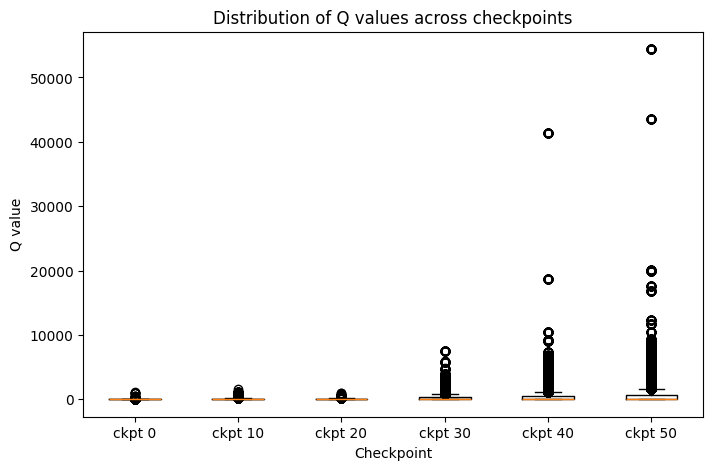

In [20]:
plt.figure(figsize=(8, 5))
plt.boxplot(qs.T, labels=[f'ckpt {i}' for i in range(0, CHECKPOINT+1, CHKPT_EVERY)])
plt.xlabel('Checkpoint')
plt.ylabel('Q value')
plt.title('Distribution of Q values across checkpoints')
plt.show()

/tmp/ipykernel_2123053/713537307.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(qs_log.T, labels=[f'ckpt {i}' for i in range(0, CHECKPOINT+1, CHKPT_EVERY)])


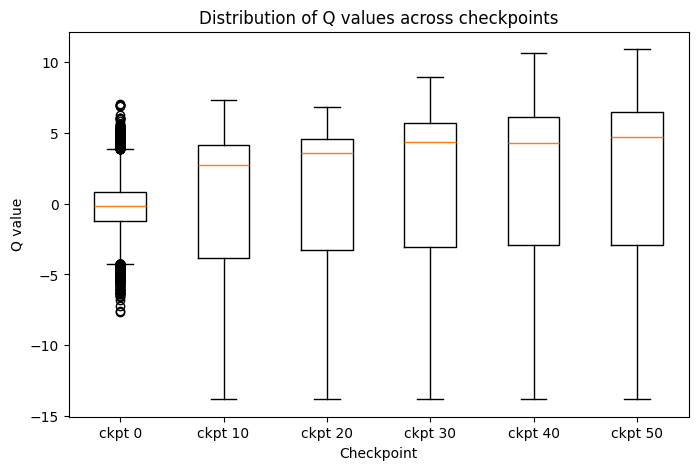

In [21]:
plt.figure(figsize=(8, 5))
plt.boxplot(qs_log.T, labels=[f'ckpt {i}' for i in range(0, CHECKPOINT+1, CHKPT_EVERY)])
plt.xlabel('Checkpoint')
plt.ylabel('Q value')
plt.title('Distribution of Q values across checkpoints')
plt.show()

/tmp/ipykernel_2123053/2809808781.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', qs_log.shape[0])


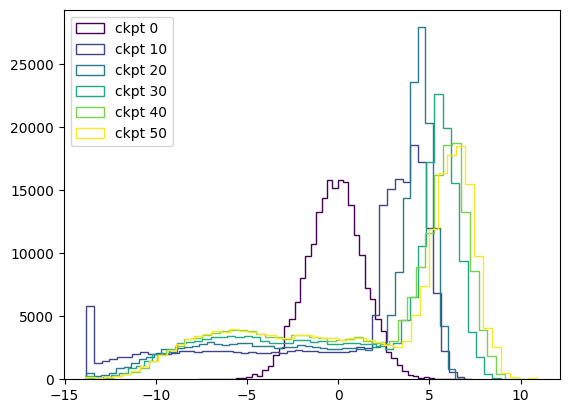

In [22]:
import matplotlib.cm as cm

cmap = cm.get_cmap('viridis', qs_log.shape[0])
for i in range(qs.shape[0]):
    plt.hist(qs_log[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.show()

# Embeddings analysis

`Value` Without actions

In [35]:
phis = []
psis = []
vs = []
CHKPT_EVERY = 10
for ckpt in range(0,CHECKPOINT+1,CHKPT_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    v, phi, psi = agent.network.select('value')(tr_states, tr_goals, actions=None, info=True)
    phis.append(np.array(phi))
    psis.append(np.array(psi))
    vs.append(np.array(v))
phis = np.array(phis)
psis = np.array(psis)
vs = np.array(vs)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /h

In [36]:
phis.shape, psis.shape, vs.shape

((6, 102400, 64), (6, 102400, 64), (6, 102400))

/tmp/ipykernel_2123053/2833449323.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', vs.shape[0])


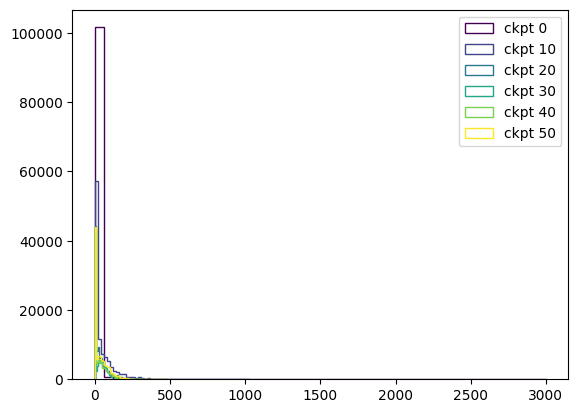

In [37]:
import matplotlib.cm as cm

cmap = cm.get_cmap('viridis', vs.shape[0])
for i in range(vs.shape[0]):
    plt.hist(vs[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.show()

/tmp/ipykernel_2123053/2849478785.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', vs_log.shape[0])


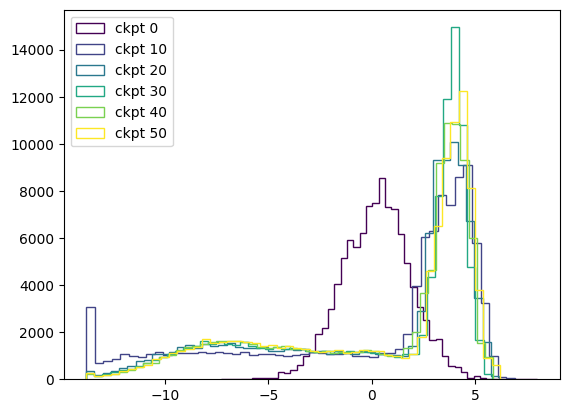

In [38]:
vs_log = value_transform(vs)
cmap = cm.get_cmap('viridis', vs_log.shape[0])
for i in range(vs_log.shape[0]):
    plt.hist(vs_log[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.show()

`Critic` With actions

In [39]:
phis = []
psis = []
vs = []
CHKPT_EVERY = 10
for ckpt in range(0,CHECKPOINT+1,CHKPT_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    v, phi, psi = agent.network.select('critic')(tr_states, tr_goals, tr_actions, info=True)
    phis.append(np.array(np.concatenate(phi)))
    psis.append(np.array(np.concatenate(psi)))
    vs.append(np.array(np.concatenate(v)))
phis = np.array(phis)
psis = np.array(psis)
vs = np.array(vs)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /h

In [40]:
phis.shape, psis.shape, vs.shape

((6, 204800, 64), (6, 204800, 64), (6, 204800))

/tmp/ipykernel_2123053/2833449323.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', vs.shape[0])


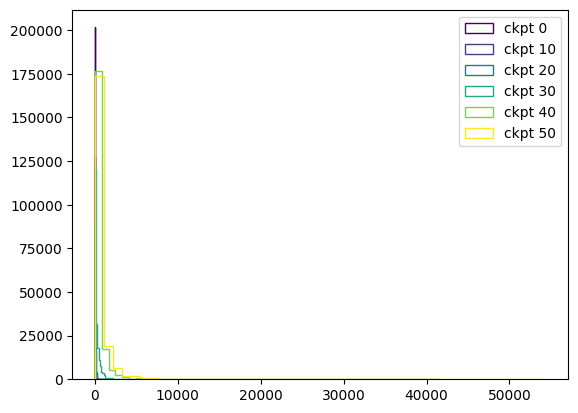

In [41]:
import matplotlib.cm as cm

cmap = cm.get_cmap('viridis', vs.shape[0])
for i in range(vs.shape[0]):
    plt.hist(vs[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.show()

/tmp/ipykernel_2123053/2849478785.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', vs_log.shape[0])


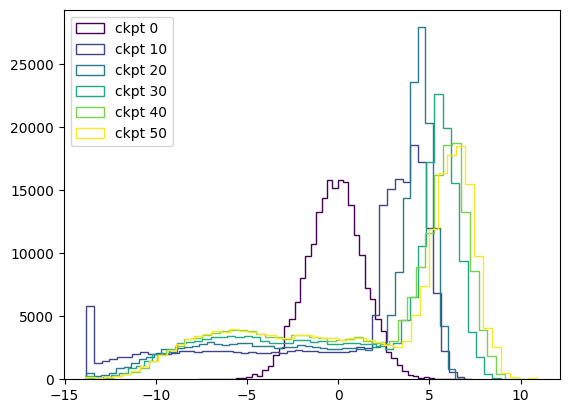

In [42]:
vs_log = value_transform(vs)
cmap = cm.get_cmap('viridis', vs_log.shape[0])
for i in range(vs_log.shape[0]):
    plt.hist(vs_log[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.show()

### Embeddings

In [43]:
phis.shape, psis.shape, vs.shape

((6, 204800, 64), (6, 204800, 64), (6, 204800))

In [46]:
phis_norms = np.linalg.norm(phis, axis=-1)
psis_norms = np.linalg.norm(psis, axis=-1)
phis_norms.shape, psis_norms.shape

((6, 204800), (6, 204800))

/tmp/ipykernel_2123053/4031157293.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', phis_norms.shape[0])


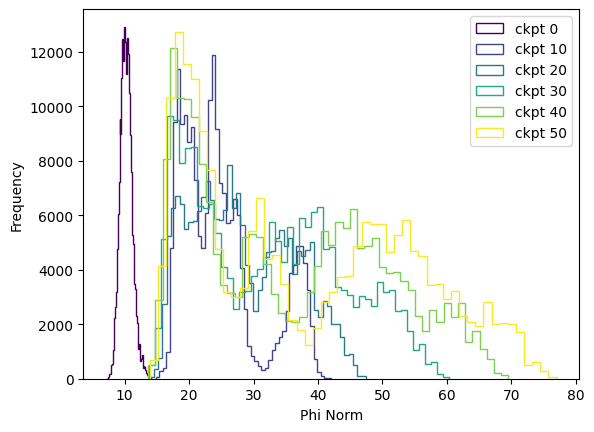

In [50]:
cmap = cm.get_cmap('viridis', phis_norms.shape[0])
for i in range(phis_norms.shape[0]):
    plt.hist(phis_norms[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Phi Norm')
plt.show()

/tmp/ipykernel_2123053/508704738.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', psis_norms.shape[0])


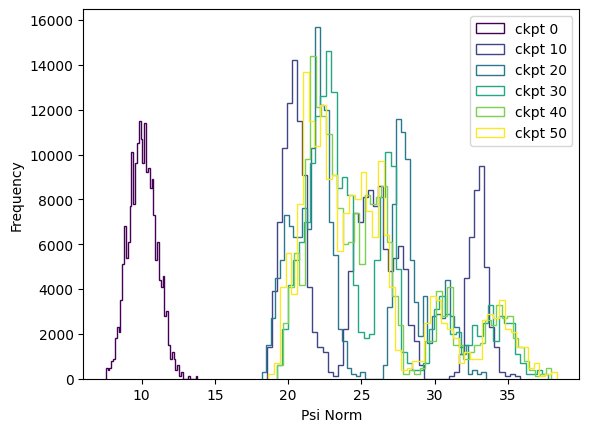

In [51]:
cmap = cm.get_cmap('viridis', psis_norms.shape[0])
for i in range(psis_norms.shape[0]):
    plt.hist(psis_norms[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Psi Norm')
plt.show()

### Get different envs

In [52]:
def get_data(num_boxes:int):
    config = Config(
        exp=ExpConfig(seed=0, name="test"),
        env=BoxPushingConfig(
            grid_size=5,
            number_of_boxes_min=num_boxes,
            number_of_boxes_max=num_boxes,
            number_of_moving_boxes_max=num_boxes
        )
    )

    # %%
    env = create_env(config.env)
    env = AutoResetWrapper(env)
    key = random.PRNGKey(config.exp.seed)
    env.step = jax.jit(jax.vmap(env.step))
    env.reset = jax.jit(jax.vmap(env.reset))
    partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
    jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
    dummy_timestep = env.get_dummy_timestep(key)

    replay_buffer = jit_wrap(
        TrajectoryUniformSamplingQueue(
            max_replay_size=config.exp.max_replay_size,
            dummy_data_sample=dummy_timestep,
            sample_batch_size=config.exp.batch_size,
            num_envs=config.exp.num_envs,
            episode_length=config.env.episode_length,
        )
    )
    buffer_state = jax.jit(replay_buffer.init)(key)

    example_batch = {
        'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
        'next_observations': dummy_timestep.grid.reshape(1, -1),
        'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
        'rewards': dummy_timestep.reward.reshape(1, -1),
        'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
        'value_goals': dummy_timestep.grid.reshape(1, -1),
        'actor_goals': dummy_timestep.grid.reshape(1, -1),
    }

    # %%
    agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

    # %%
    keys = random.split(random.PRNGKey(0), NUM_ENVS)
    state, info = env.reset(keys)

    # %%
    dummy_timestep = env.get_dummy_timestep(key)

    replay_buffer = jit_wrap(
        TrajectoryUniformSamplingQueue(
            max_replay_size=config.exp.max_replay_size,
            dummy_data_sample=dummy_timestep,
            sample_batch_size=config.exp.batch_size,
            num_envs=config.exp.num_envs,
            episode_length=config.env.episode_length,
        )
    )
    buffer_state = jax.jit(replay_buffer.init)(key)


    data_key = random.PRNGKey(0)
    _, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
    buffer_state = replay_buffer.insert(buffer_state, timesteps)

    use_targets = False


    timesteps_tr = jax.lax.cond(
        use_targets,
        lambda: timesteps.replace(),
        lambda: timesteps.replace(
            grid=GridStatesEnum.remove_targets(timesteps.grid),
            goal=GridStatesEnum.remove_targets(timesteps.goal)
        )
    )

    tr_states = timesteps_tr.grid
    tr_actions = timesteps_tr.action
    tr_goals = timesteps_tr.goal
    tr_states.shape, tr_goals.shape, tr_actions.shape
    tr_states, tr_goals, tr_actions = tr_states.reshape((-1, tr_states.shape[-2],tr_states.shape[-1])), tr_goals.reshape((-1, tr_goals.shape[-2],tr_goals.shape[-1])), tr_actions.reshape((-1,))
    tr_states.shape, tr_goals.shape, tr_actions.shape
    tr_states, tr_goals = tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1)
    tr_states.shape, tr_goals.shape, tr_actions.shape
    return tr_states, tr_goals, tr_actions

# Box = 1

In [63]:
tr_states, tr_goals, tr_actions = get_data(1)
tr_states.shape, tr_goals.shape, tr_actions.shape

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl


((102400, 25), (102400, 25), (102400,))

In [66]:
for i in range(0, 102400, 1024):
    print("==================================")
    print(tr_states[i].reshape(5,5))
    print(tr_goals[i].reshape(5,5))


[[0 1 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
[[0 1 0 0 0]
 [3 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
[[0 1 0 0 0]
 [0 3 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
[[0 1 0 0 0]
 [0 0 3 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
[[0 1 0 0 0]
 [0 3 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
[[0 5 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
[[0 4 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 4 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 

In [55]:
phis = []
psis = []
vs = []
CHKPT_EVERY = 10
for ckpt in range(0,CHECKPOINT+1,CHKPT_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    v, phi, psi = agent.network.select('critic')(tr_states, tr_goals, tr_actions, info=True)
    phis.append(np.array(np.concatenate(phi)))
    psis.append(np.array(np.concatenate(psi)))
    vs.append(np.array(np.concatenate(v)))
phis = np.array(phis)
psis = np.array(psis)
vs = np.array(vs)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /h

In [56]:
phis.shape, psis.shape, vs.shape

((6, 204800, 64), (6, 204800, 64), (6, 204800))

### Embeddings

In [59]:
phis.shape, psis.shape, vs.shape

((6, 204800, 64), (6, 204800, 64), (6, 204800))

In [60]:
phis_norms = np.linalg.norm(phis, axis=-1)
psis_norms = np.linalg.norm(psis, axis=-1)
phis_norms.shape, psis_norms.shape

((6, 204800), (6, 204800))

/tmp/ipykernel_2123053/4031157293.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', phis_norms.shape[0])


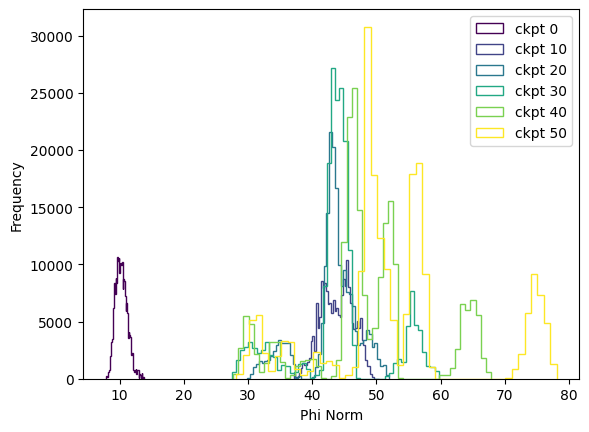

In [61]:
cmap = cm.get_cmap('viridis', phis_norms.shape[0])
for i in range(phis_norms.shape[0]):
    plt.hist(phis_norms[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Phi Norm')
plt.show()

/tmp/ipykernel_2123053/508704738.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', psis_norms.shape[0])


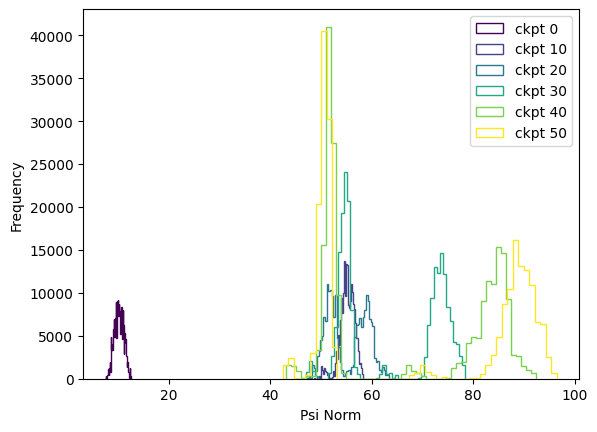

In [62]:
cmap = cm.get_cmap('viridis', psis_norms.shape[0])
for i in range(psis_norms.shape[0]):
    plt.hist(psis_norms[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Psi Norm')
plt.show()

# Box=9

In [67]:
tr_states, tr_goals, tr_actions = get_data(9)
tr_states.shape, tr_goals.shape, tr_actions.shape

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl


((102400, 25), (102400, 25), (102400,))

In [68]:
for i in range(0, 102400, 1024):
    print("==================================")
    print(tr_states[i].reshape(5,5))
    print(tr_goals[i].reshape(5,5))


[[0 1 0 0 0]
 [1 1 1 0 0]
 [5 0 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [1 1 1 0 0]
 [4 0 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [1 1 1 0 0]
 [0 4 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [1 1 1 0 0]
 [0 5 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [1 1 1 0 0]
 [3 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [5 1 1 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [4 1 1 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[ 0  1  0  0  0]
 [ 0 11  1  0  0]
 [ 0  1  0  0  0]
 [ 0  0  1  1  0]
 [ 0

In [69]:
phis = []
psis = []
vs = []
CHKPT_EVERY = 10
for ckpt in range(0,CHECKPOINT+1,CHKPT_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    v, phi, psi = agent.network.select('critic')(tr_states, tr_goals, tr_actions, info=True)
    phis.append(np.array(np.concatenate(phi)))
    psis.append(np.array(np.concatenate(psi)))
    vs.append(np.array(np.concatenate(v)))
phis = np.array(phis)
psis = np.array(psis)
vs = np.array(vs)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /h

In [70]:
phis.shape, psis.shape, vs.shape

((6, 204800, 64), (6, 204800, 64), (6, 204800))

### Embeddings

In [71]:
phis.shape, psis.shape, vs.shape

((6, 204800, 64), (6, 204800, 64), (6, 204800))

In [82]:
phis_norms = np.linalg.norm(phis, axis=-1)
psis_norms = np.linalg.norm(psis, axis=-1)
dot_prods = (phis * psis / jnp.sqrt(64)).sum(axis=-1)
phis_norms.shape, psis_norms.shape, dot_prods.shape

((6, 204800), (6, 204800), (6, 204800))

/tmp/ipykernel_2123053/4031157293.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', phis_norms.shape[0])


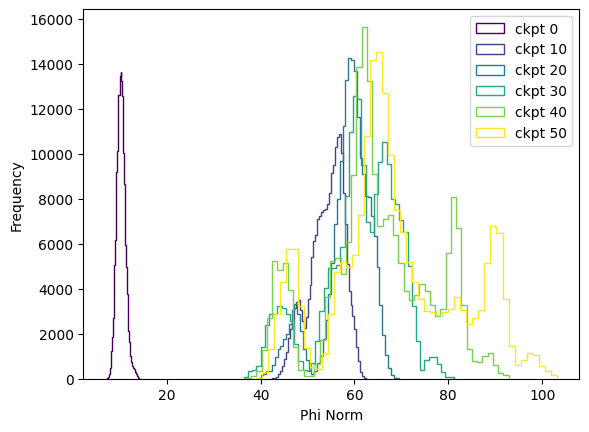

In [83]:
cmap = cm.get_cmap('viridis', phis_norms.shape[0])
for i in range(phis_norms.shape[0]):
    plt.hist(phis_norms[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Phi Norm')
plt.show()

/tmp/ipykernel_2123053/508704738.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', psis_norms.shape[0])


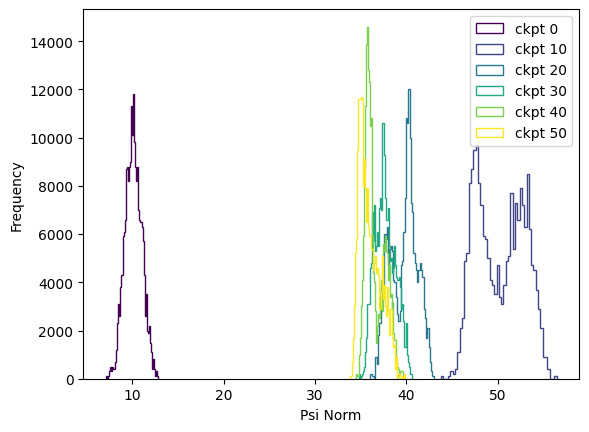

In [84]:
cmap = cm.get_cmap('viridis', psis_norms.shape[0])
for i in range(psis_norms.shape[0]):
    plt.hist(psis_norms[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Psi Norm')
plt.show()

/tmp/ipykernel_2123053/454729847.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', dot_prods.shape[0])


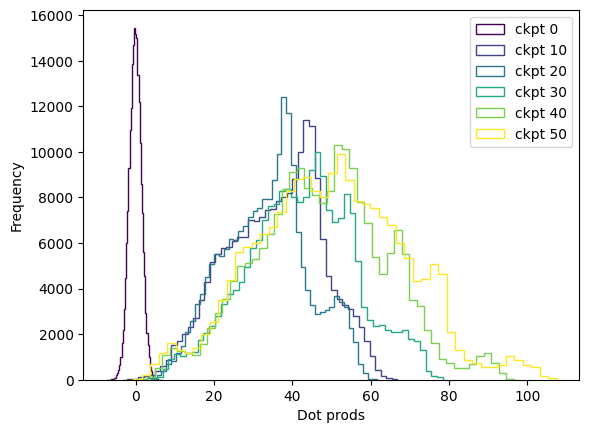

In [86]:
cmap = cm.get_cmap('viridis', dot_prods.shape[0])
for i in range(dot_prods.shape[0]):
    plt.hist(dot_prods[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Dot prods')
plt.show()

# Box = 9

In [105]:
tr_states, tr_goals, tr_actions = get_data(9)
tr_states.shape, tr_goals.shape, tr_actions.shape

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl


((102400, 25), (102400, 25), (102400,))

In [106]:
for i in range(0, 102400, 1024):
    print("==================================")
    print(tr_states[i].reshape(5,5))
    print(tr_goals[i].reshape(5,5))


[[0 1 0 0 0]
 [1 1 1 0 0]
 [5 0 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [1 1 1 0 0]
 [4 0 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [1 1 1 0 0]
 [0 4 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [1 1 1 0 0]
 [0 5 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [1 1 1 0 0]
 [3 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [5 1 1 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[0 1 0 0 0]
 [4 1 1 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [3 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]]
[[ 0  1  0  0  0]
 [ 0 11  1  0  0]
 [ 0  1  0  0  0]
 [ 0  0  1  1  0]
 [ 0

In [107]:
phis = []
psis = []
vs = []
CHKPT_EVERY = 10
for ckpt in range(0,CHECKPOINT+1,CHKPT_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    v, phi, psi = agent.network.select('critic')(tr_states, tr_goals, tr_actions, info=True)
    phis.append(np.array(np.concatenate(phi)))
    psis.append(np.array(np.concatenate(psi)))
    vs.append(np.array(np.concatenate(v)))
phis = np.array(phis)
psis = np.array(psis)
vs = np.array(vs)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_10.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_40.pkl
Restored from /h

In [108]:
phis.shape, psis.shape, vs.shape

((6, 204800, 64), (6, 204800, 64), (6, 204800))

### Embeddings

In [109]:
phis.shape, psis.shape, vs.shape

((6, 204800, 64), (6, 204800, 64), (6, 204800))

In [110]:
phis_norms = np.linalg.norm(phis, axis=-1)
psis_norms = np.linalg.norm(psis, axis=-1)
dot_prods = (phis * psis / jnp.sqrt(64)).sum(axis=-1)
phis_norms.shape, psis_norms.shape, dot_prods.shape

((6, 204800), (6, 204800), (6, 204800))

/tmp/ipykernel_2123053/4031157293.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', phis_norms.shape[0])


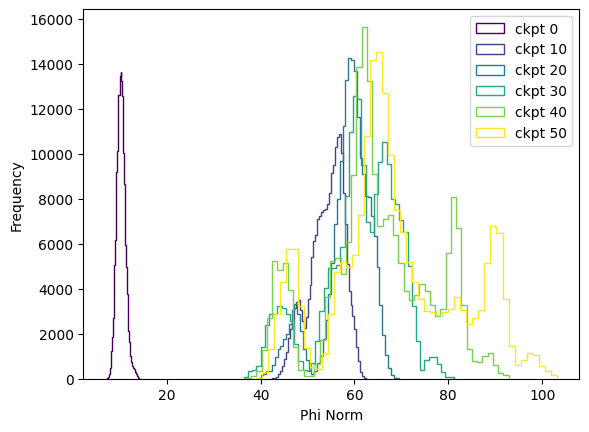

In [111]:
cmap = cm.get_cmap('viridis', phis_norms.shape[0])
for i in range(phis_norms.shape[0]):
    plt.hist(phis_norms[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Phi Norm')
plt.show()

/tmp/ipykernel_2123053/508704738.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', psis_norms.shape[0])


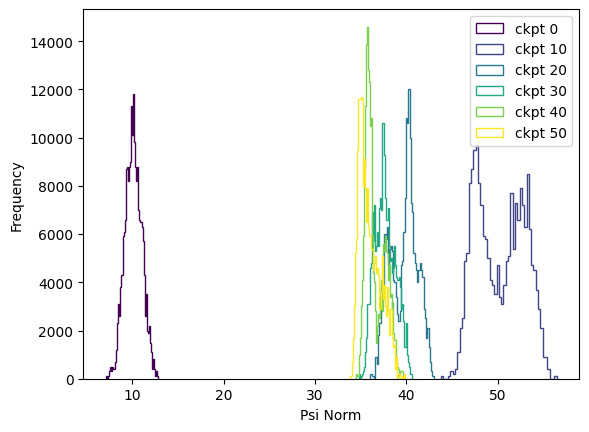

In [112]:
cmap = cm.get_cmap('viridis', psis_norms.shape[0])
for i in range(psis_norms.shape[0]):
    plt.hist(psis_norms[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Psi Norm')
plt.show()

/tmp/ipykernel_2123053/454729847.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', dot_prods.shape[0])


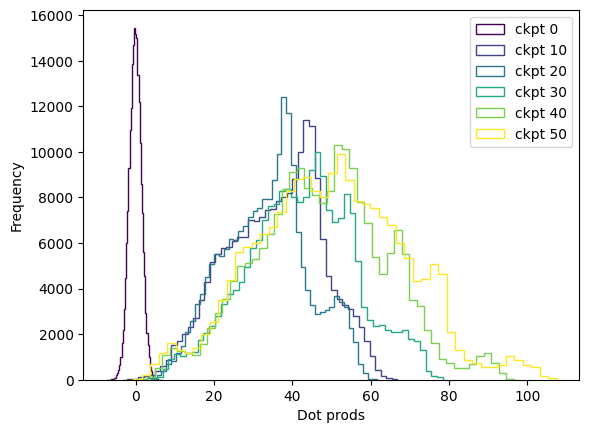

In [113]:
cmap = cm.get_cmap('viridis', dot_prods.shape[0])
for i in range(dot_prods.shape[0]):
    plt.hist(dot_prods[i], bins=50, alpha=1.0, histtype='step', 
             label=f'ckpt {i*CHKPT_EVERY}', color=cmap(i))
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Dot prods')
plt.show()

#### Umaps

/home/mbortkie/repos/crl_subgoal/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


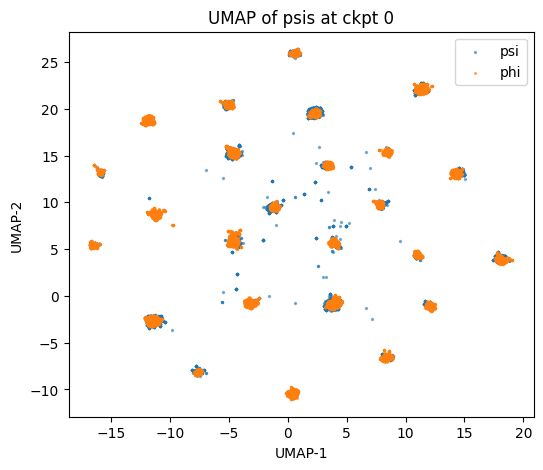

/home/mbortkie/repos/crl_subgoal/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


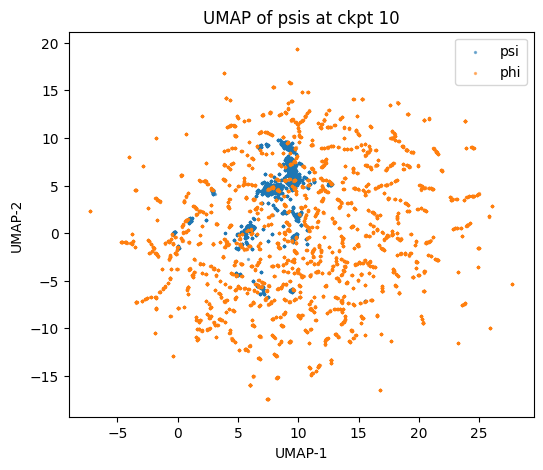

/home/mbortkie/repos/crl_subgoal/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


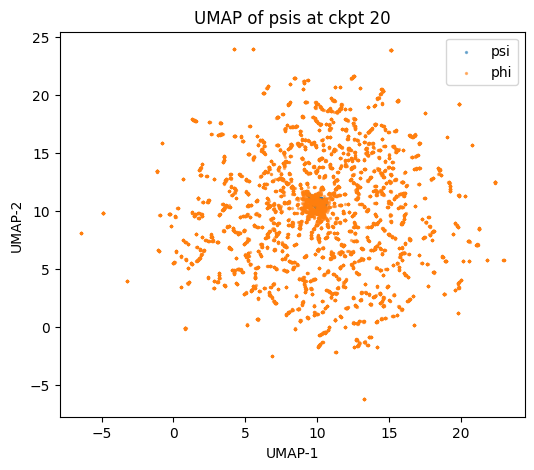

/home/mbortkie/repos/crl_subgoal/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


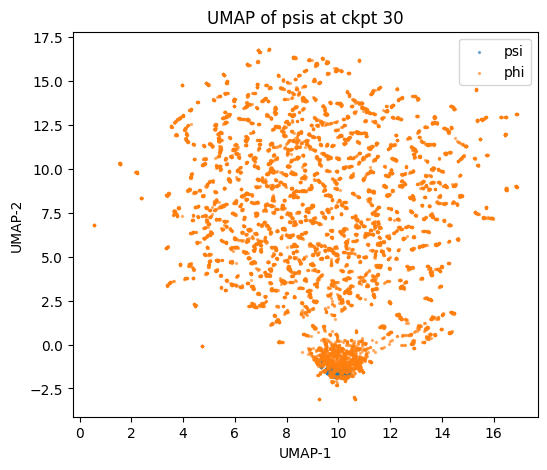

/home/mbortkie/repos/crl_subgoal/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


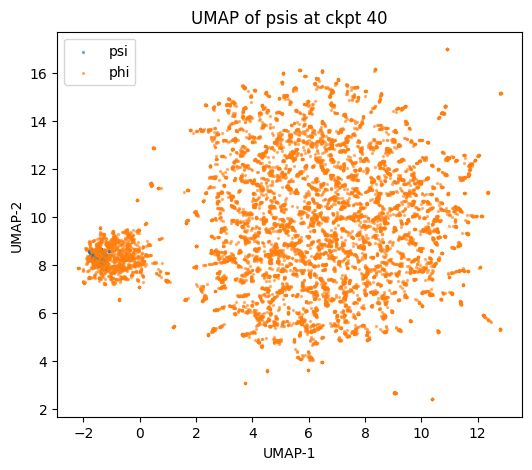

/home/mbortkie/repos/crl_subgoal/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


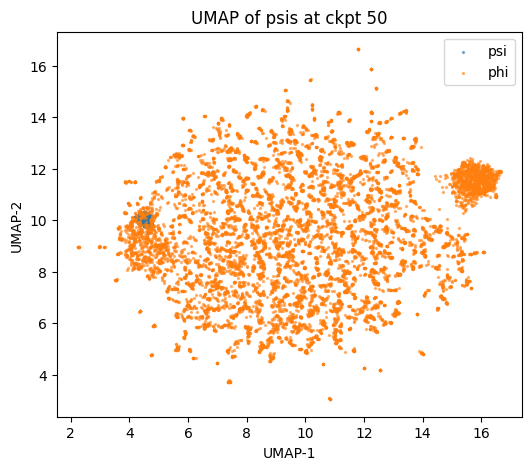

In [114]:
import umap
n_points = 10000
for i in range(psis.shape[0]):
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding_phi = reducer.fit_transform(phis[i][:n_points])
    embedding_psi = reducer.transform(psis[i][:n_points])

    plt.figure(figsize=(6, 5))
    plt.scatter(embedding_psi[:, 0], embedding_psi[:, 1], s=2, alpha=0.5, label="psi")
    plt.scatter(embedding_phi[:, 0], embedding_phi[:, 1], s=2, alpha=0.5, label="phi")
    plt.title(f'UMAP of psis at ckpt {i*CHKPT_EVERY}')
    plt.xlabel('UMAP-1')
    plt.ylabel('UMAP-2')
    plt.legend()
    plt.show()


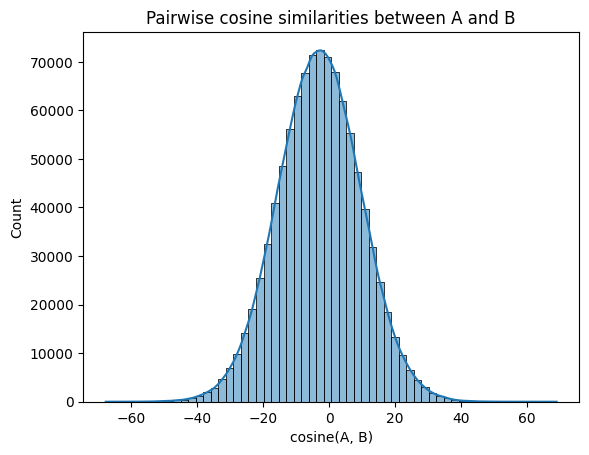

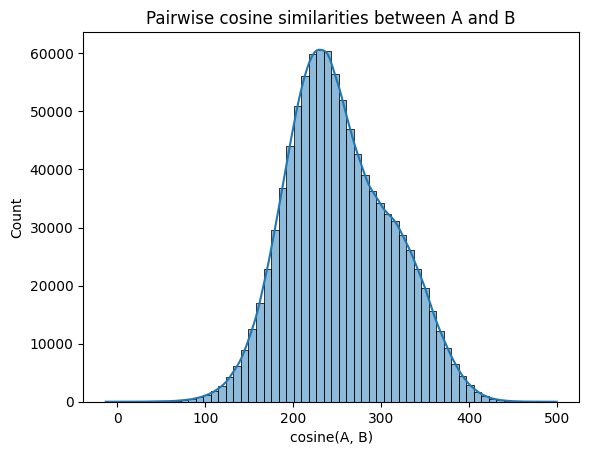

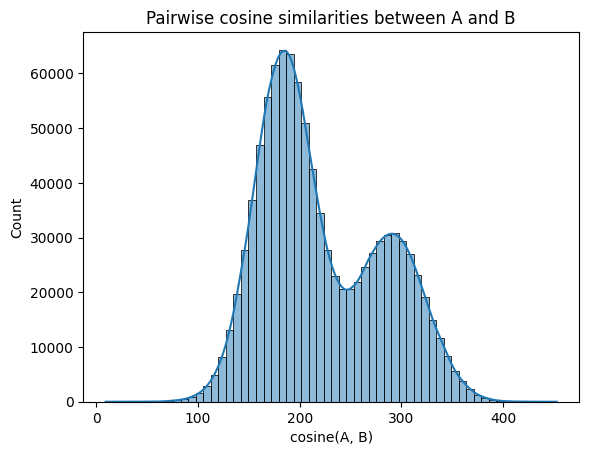

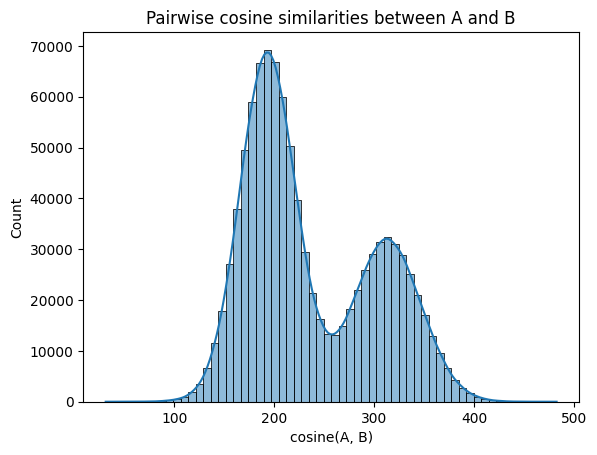

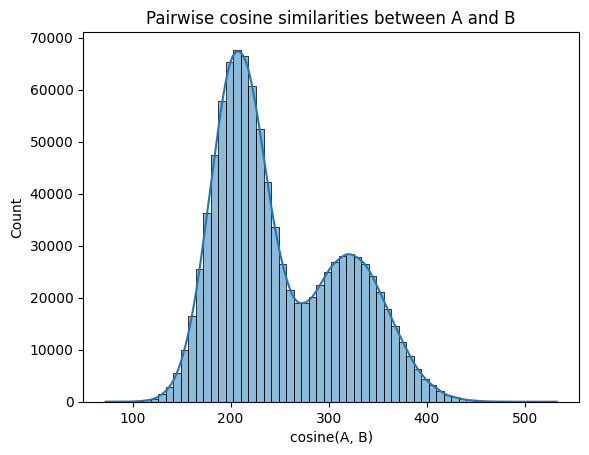

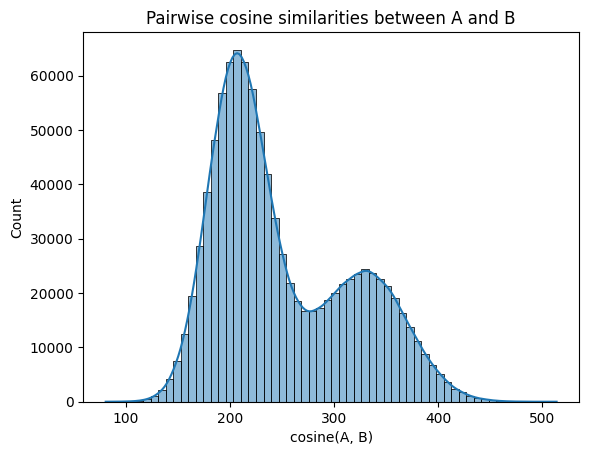

In [118]:
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd, subspace_angles
from sklearn.decomposition import PCA

n_points = 1000
for i in range(psis.shape[0]):
    A = psis[i][:n_points]
    B = phis[i][:n_points]
    # Example: A (nA x d), B (nB x d)
    # Normalize rows if you want cosine similarity:
    # A = normalize(A, axis=1)
    # B = normalize(B, axis=1)

    # 1) Pairwise cosine similarities (A x B)
    cos_AB = A @ B.T  # shape (nA, nB)

    # Simple histogram / violin for between-group cosines
    plt.figure()
    sns.histplot(cos_AB.ravel(), bins=60, kde=True)
    plt.title("Pairwise cosine similarities between A and B")
    plt.xlabel("cosine(A, B)")
    plt.show()


# Different number of boxes q_means

In [75]:
q_means = []
for boxes in range(1,10):
    tr_states, tr_goals, tr_actions = get_data(boxes)
    q1, q2 = agent.network.select('critic')(tr_states, tr_goals, tr_actions)
    print(f"Boxes: {boxes}, Q means: {q1.mean()}, {q2.mean()}")
    q_means.append([q1.mean(), q2.mean()])

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl
Boxes: 1, Q means: inf, inf
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl
Boxes: 2, Q means: 2690391.0, 1.7697319971874406e+17
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl
Boxes: 3, Q means: 390.43060302734375, 372.7701721191406
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250820_001752/runs/CORRECTLY_fixed_bug_with_solved_state_moving_boxes_5_grid_5_range_3_7_alpha_0.1/params_50.pkl
Boxes: 4, Q means: 674.1598510742188, 619.626220703125
Restored from /home

In [76]:
q_means = np.array(q_means)

In [77]:
for boxes, q_mean in enumerate(q_means.mean(axis=1), start=1):
    print(f"boxes: {boxes}, q_mean: {q_mean:.2f}")

boxes: 1, q_mean: inf
boxes: 2, q_mean: 88486599859372032.00
boxes: 3, q_mean: 381.60
boxes: 4, q_mean: 646.89
boxes: 5, q_mean: 672.04
boxes: 6, q_mean: 508.01
boxes: 7, q_mean: 395.87
boxes: 8, q_mean: 14375662487863296.00
boxes: 9, q_mean: inf


(102400,)